This step $4$ is not a proper separate step, but it is an evolution of the step $3$. So, it is done instead of the step $3$.

With step $3$ we simply compute `X`, `min_half_height_up`, `min_half_height_down`, `first_bar_x` and `last_bar_x`. So, we compute global quantities about the whole barcode.

Now we want to compute this more specifically at a local level, for each bar of the barcode. Namely, we want to compute the following things.
- List `bars_start` which contains, for each bar $b$, its starting pixel `bars_start[b]`.
- List `bars_width` which contains, for each bar $b$, its width `bars_width[b]`.
- List `bars_half_height_up` which contains, for each bar $b$, its half height up `bars_half_height_up[b]`.
- List `bars_half_height_down` which contains, for each bar $b$, its half height up `bars_half_height_down[b]`.

Why do we want to compute that? 
- For debug purposes
- Because we will need them in the end

So, we compute these lists, at a local level. If we compute these, we don't need to directly compute the classici quantities `X`, `min_half_height_up`, `min_half_height_down`, `first_bar_x` and `last_bar_x`: we can infer them from the above lists.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math

In [2]:
import importlib  

module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi

module = importlib.import_module('2) rotate_image_boundingBox')
rotate_image_boundingBox = module.rotate_image_boundingBox

module = importlib.import_module('3) fix_horizontalBars_case')
fix_horizontalBars_case = module.fix_horizontalBars_case

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [4]:
image_path = f'../other images/1.png'

(200, 350, 3)


Text(0.5, 1.0, 'Original image')

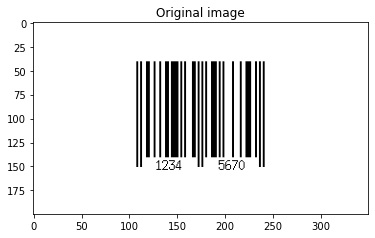

In [5]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Original image')

array([[ 97.,  31.],
       [257.,  31.],
       [ 97., 165.],
       [257., 165.]], dtype=float32)

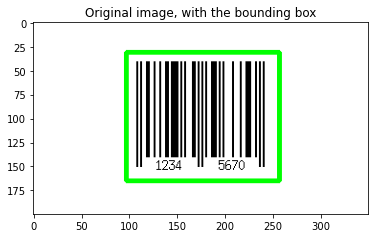

In [6]:
bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
bb_points_sorted

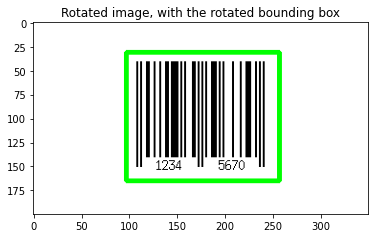

In [7]:
image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=True)

In [8]:
image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=True)

In [9]:
gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                             int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]

Text(0.5, 1.0, 'ROI image')

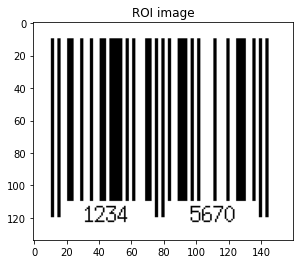

In [10]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.title('ROI image')

## THRESHOLDING OF THE IMAGE
First of all, we threshold the ROI image. Otsu's alogirthm.

Text(0.5, 1.0, 'Thresholded ROI image')

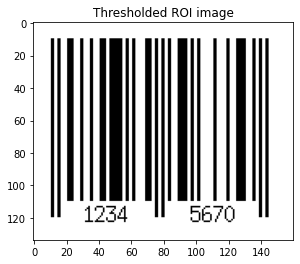

In [11]:
_ ,ROI_thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure()
plt.imshow(ROI_thresh, 'gray')
plt.title('Thresholded ROI image')

## ALGORITHM 1
It's an extension of the *SOLUTION 1.1* presented in the previous notebook.

In [12]:
# INIZIALIZATION
half_height = int(bb_height/2)
half_height_index = half_height-1

bars_start = []
bars_width = []
bars_halfHeightUp = []
bars_halfHeightDown = []

i = 0  # Index for iterating over the pixels

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:
    
    # White pixel: we go to the next pixel
    if ROI_thresh[half_height_index, i]==255:
        i += 1
        continue
    
    # Black pixel
    # 'i' is the first pixel in this current barcode bar
        
    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1
    
    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height_index, i_end]==0:
        X_curr += 1
        i_end += 1
       
    # Now we search upward and downward along the vertical line 'i_med'.
    i_med = int((i+i_end)/2)
    # Index for goind upward.
    j_up = half_height_index-1
    # Index for goind downward.
    j_down = half_height_index+1
    # Half upward height of this current bar
    half_height_up_curr = 0
    # Half downard height of this current bar
    half_height_down_curr = 0
    
    # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
    # `half_height_down_curr`
    up_reached = j_up<0 or (ROI_thresh[j_up, i_med]==255 and  ROI_thresh[j_up, i_med-1]==255 and ROI_thresh[j_up, i_med+1]==255)
    down_reached = j_down<0 or (ROI_thresh[j_down, i_med]==255 and  ROI_thresh[j_down, i_med-1]==255 and ROI_thresh[j_down, i_med+1]==255)
    while not up_reached or not down_reached:
        if not up_reached:
            j_up -= 1
            half_height_up_curr += 1
        if not down_reached:
            j_down += 1
            half_height_down_curr += 1
        up_reached = j_up<0 or (ROI_thresh[j_up, i_med]==255 and  ROI_thresh[j_up, i_med-1]==255 and ROI_thresh[j_up, i_med+1]==255)
        down_reached = j_down<0 or (ROI_thresh[j_down, i_med]==255 and  ROI_thresh[j_down, i_med-1]==255 and ROI_thresh[j_down, i_med+1]==255)
        
    bars_start.append(i)
    bars_width.append(X_curr)
    bars_halfHeightUp.append(half_height_up_curr)
    bars_halfHeightDown.append(half_height_down_curr)
        
    # We update `i`: we pass to the white pixel right after the current bar
    i = i_end


### Compute the classic quantities

In [13]:
first_bar_x = min(bars_start)

last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1

X = min(bars_width)

min_half_height_up = min(bars_halfHeightUp)

min_half_height_down = min(bars_halfHeightDown)

In [14]:
print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

first_bar_x: 11
last_bar_x: 144
X: 2
min_half_height_up: 56
min_half_height_down: 43


They are correct! Compare them with the previous notebook.

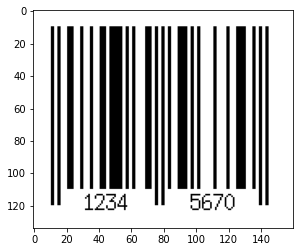

In [15]:
plt.imshow(roi_image, 'gray')

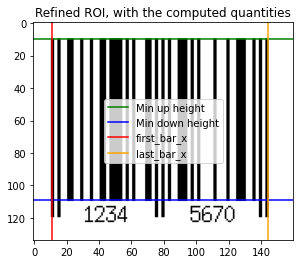

In [16]:
%matplotlib inline
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

### Bars inspection
Let's inspect the computed quantities bar by bar.

In [17]:
print('bars_start: ', bars_start)
print('len:', len(bars_start))

bars_start:  [11, 15, 21, 29, 35, 41, 47, 57, 61, 69, 75, 79, 83, 89, 97, 101, 111, 119, 125, 135, 139, 143]
len: 22


In [18]:
print('bars_width: ', bars_width)
print('len:', len(bars_width))

bars_width:  [2, 2, 4, 2, 2, 4, 8, 2, 2, 4, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2]
len: 22


In [19]:
print('bars_halfHeightUp: ', bars_halfHeightUp)
print('len:', len(bars_halfHeightUp))

bars_halfHeightUp:  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
len: 22


In [20]:
print('bars_halfHeightDown: ', bars_halfHeightDown)
print('len:', len(bars_halfHeightDown))

bars_halfHeightDown:  [53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53]
len: 22


<IPython.core.display.Javascript object>


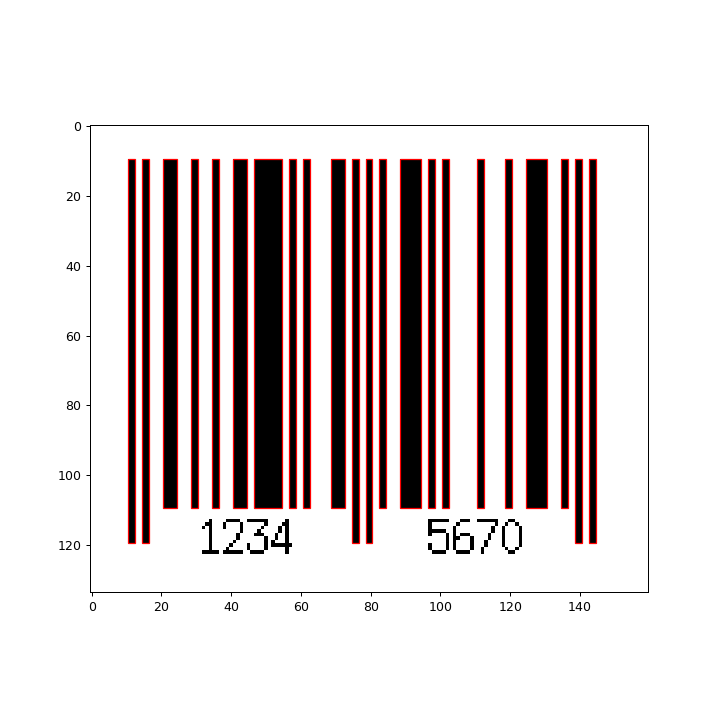

In [21]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi_image, 'gray')
n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

## ALGORITHM 2

Its the extension of the *SOLUTION 2.2* presented in the previous notebook.

In [32]:
half_height = int(bb_height/2)
half_height_index = half_height-1

# INIZIALIZATION
i = 0  # Index for iterating over the pixels

bars_start = []
bars_width = []
bars_halfHeightUp = []
bars_halfHeightDown = []

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:

    # White pixel: we go to the next pixel
    if ROI_thresh[half_height_index, i]==255:
        i += 1
        continue

    # Black pixel
    # 'i' is the first pixel in this current barcode bar

    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1

    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height_index, i_end]==0:
        X_curr += 1
        i_end += 1

    # Now we search upward and downward
    # Index for goind upward.
    j_up = half_height_index-1
    # Index for goind downward.
    j_down = half_height_index+1
    # Half upward height of this current bar
    half_height_up_curr = 0
    # Half downard height of this current bar
    half_height_down_curr = 0

    # Flag saying whether the max up height has been reached or not
    up_reached = j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33         
    # Flag saying whether the max down height has been reached or not
    down_reached = j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33

    #print(7)

    # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
    # `half_height_down_curr`
    while not up_reached or not down_reached:

        if not up_reached:
            half_height_up_curr += 1
        if not down_reached:
            half_height_down_curr += 1

        # We separate the increasing of `X_curr` left, right, up, down: 4 possibilities

        # Left increasing of `X_curr` on the vertical level `j_up`. "Left increasing" means before the index `i`.
        X_inc_left_up = 0
        # Right increasing of `X_curr` on the vertical level `j_up`. "Right increasing" means before the index `i_end`.
        X_inc_right_up = 0
        # Left increasing of `X_curr` on the vertical level `j_down`. "Left increasing" means before the index `i`.
        X_inc_left_down = 0
        # Right increasing of `X_curr` on the vertical level `j_down`. "Right increasing" means before the index `i_end`.
        X_inc_right_down = 0

        if not up_reached:  # Vertical level `j_up`
            while i-1>=0 and ROI_thresh[j_up, i-1]==0:  # Left expansion of `X_curr`
                #print(8)
                X_inc_left_up += 1
                i -= 1 
            while i_end<bb_width and ROI_thresh[j_up, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_up += 1
                i_end +=1 
        if not down_reached:  # Vertical level `j_down`
            while i-1>=0 and ROI_thresh[j_down, i-1]==0:  # Left expansion of `X_curr`
                X_inc_left_down += 1
                i -= 1 
            while i_end<bb_width and ROI_thresh[j_down, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_down += 1
                i_end +=1 

        # Update `X_curr`, adding the maximum, both left and right.
        X_curr += max([X_inc_left_up,X_inc_left_down]) + max([X_inc_right_up,X_inc_right_down])

        j_up -= 1
        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33              

        j_down += 1
        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33


    # Now we have computed the actual `X_curr`

    bars_start.append(i)
    bars_width.append(X_curr)
    bars_halfHeightUp.append(half_height_up_curr)
    bars_halfHeightDown.append(half_height_down_curr)

    # We update `i`: we pass to the white pixel right after the current bar
    i = i_end

### Compute the classic quantities

In [33]:
first_bar_x = min(bars_start)

last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1

X = min(bars_width)

min_half_height_up = min(bars_halfHeightUp)

min_half_height_down = min(bars_halfHeightDown)

In [34]:
print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

first_bar_x: 11
last_bar_x: 144
X: 2
min_half_height_up: 56
min_half_height_down: 43


They are correct! Compare them with the previous notebook.

In [35]:
plt.imshow(roi_image, 'gray')

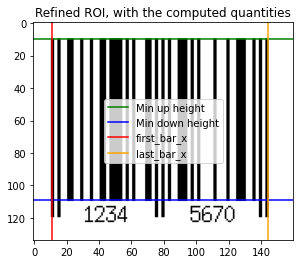

In [36]:
%matplotlib inline
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

### Bars inspection
Let's inspect the computed quantities bar by bar.

In [37]:
print('bars_start: ', bars_start)
print('len:', len(bars_start))

bars_start:  [11, 15, 21, 29, 35, 41, 47, 57, 61, 69, 75, 79, 83, 89, 97, 101, 111, 119, 125, 135, 139, 143]
len: 22


In [38]:
print('bars_width: ', bars_width)
print('len:', len(bars_width))

bars_width:  [2, 2, 4, 2, 2, 4, 8, 2, 2, 4, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2]
len: 22


In [39]:
print('bars_halfHeightUp: ', bars_halfHeightUp)
print('len:', len(bars_halfHeightUp))

bars_halfHeightUp:  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
len: 22


In [40]:
print('bars_halfHeightDown: ', bars_halfHeightDown)
print('len:', len(bars_halfHeightDown))

bars_halfHeightDown:  [53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53]
len: 22


<IPython.core.display.Javascript object>


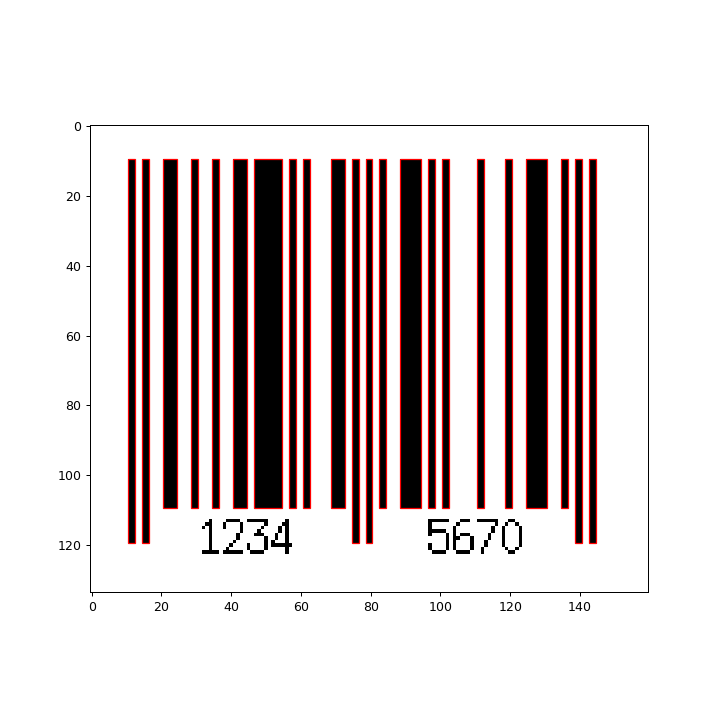

In [41]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi_image, 'gray')
n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

## ALGORITHM 3

The algorithm $2$ dynamically updates $i$ and $X_{curr}$ while goind upward and downward, in order to compute more robust estimation of $i$ and $X_{curr}$.

However, the algorithm $1$ does that in a "naive" way: every time a black pixel is found outside the borders, the rectangle is enlarged accordingly. However, this can be problematic, since also black pixels can be errors. In particular, a single black pixels is enough for enlarging the rectangle. Overestimation of the actual rectangle.

Idea for a more robust estimation: compute the **mean**. Basically, we compute the mean $X_{curr}$.

### Idea
We are in a current bar, with starting pixel `i`, last pixel `i_end` and width `X_curr`. For now, we have just scanned the middle horizontal line, we haven't't gone upward/downward yet.

We take the middle $i_{mid}$ between $i$ and $i_{end}$: this vertical line will be our reference line. 

We go upward and downward, at the same time. In each level (either `j_up` or `j_down`), we compute `X_curr_left_tmp` and `X_curr_right_tmp` which are, respectively, the width to the left of the bar on that level and the width to the right of the bar on that level. We compute that in each vertical level (both up and down): in the end, we compute the overall `X_curr_left` and `X_curr_right` as the mean of all these quantities.

Actually, we compute and update `X_curr_left` and `X_curr_right` at each level: $X_{curr\_left} = (l * X_{curr\_left} + X_{curr\_left\_tmp}) / (l+1)$, where $l$ is the number of levels seen since now. At each level, we compute also $X_{curr}$, as $X_{curr\_left\_tmp}+X_{curr\_right\_tmp}+1$.

**So, the overall idea is simple: we compute the mean $X_{curr}$ to the left and to the right with respect to $i_{mid}$, and then we compute $X_{curr}$ as the sum of the two**. (We divide the computation left and right because this is more robust, since the middle vertical line contains usually less errors).

We stop, either upward or downward, when we find a level in which the number of black pixels is less than the $25$% of $X_{curr}$.

Finally, the starting pixel $i$ of that bar is computed as $\lceil i_{mid} - X_{curr\_left} \rceil$. 

In [12]:
half_height = int(bb_height/2)
half_height_index = half_height-1

# INIZIALIZATION
i = 0  # Index for iterating over the pixels

bars_start = []
bars_width = []
bars_halfHeightUp = []
bars_halfHeightDown = []

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:

    # White pixel: we go to the next pixel
    if ROI_thresh[half_height_index, i]==255:
        i += 1
        continue

    # Black pixel
    # 'i' is the first pixel in this current barcode bar

    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1

    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height_index, i_end]==0:
        X_curr += 1
        i_end += 1
        
    i_next = i_end

    # Now we search upward and downward
    # Index for goind upward.
    j_up = half_height_index-1
    # Index for goind downward.
    j_down = half_height_index+1
    # Half upward height of this current bar
    half_height_up_curr = 0
    # Half downard height of this current bar
    half_height_down_curr = 0
    
    # Number of vertical levels explored so far
    l = 1
    i_med = int((i+i_end-1)/2)
    X_curr_left = i_med-i
    X_curr_right = i_end-i_med-1

    # Flag saying whether the max up height has been reached or not
    up_reached = j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.3
    # Flag saying whether the max down height has been reached or not
    down_reached = j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.3
    #print(7)

    # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
    # `half_height_down_curr`
    while not up_reached or not down_reached:

        if not up_reached:
            half_height_up_curr += 1
        if not down_reached:
            half_height_down_curr += 1
        
        if not up_reached:  # Vertical level `j_up`
            X_curr_left_up = 0
            X_curr_right_up = 0
            ii = 1
            left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
            right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
            while not left_reached or not right_reached:  
                if not left_reached:
                    X_curr_left_up += 1
                if not right_reached:
                    X_curr_right_up += 1
                ii += 1 
                left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
                right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
            X_curr_left = (l*X_curr_left + X_curr_left_up)/(l+1)
            X_curr_right = (l*X_curr_right + X_curr_right_up)/(l+1)
            l = l+1
            
        if not down_reached:  # Vertical level `j_up`
            X_curr_left_down = 0
            X_curr_right_down = 0
            ii = 1
            left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
            right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
            while not left_reached or not right_reached:  
                if not left_reached:
                    X_curr_left_down += 1
                if not right_reached:
                    X_curr_right_down += 1
                ii += 1 
                left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
                right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
            X_curr_left = (l*X_curr_left + X_curr_left_down)/(l+1)
            X_curr_right = (l*X_curr_right + X_curr_right_down)/(l+1)
            l = l+1
            
        i = math.ceil(i_med-X_curr_left)
        i_end = int(i_med+X_curr_right)+1
        i_med = int((i+i_end-1)/2)
        X_curr = int(X_curr_left+X_curr_right)+1

        j_up -= 1
        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33              

        j_down += 1
        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33     


    # Now we have computed the actual `X_curr`  

    bars_start.append(i)
    bars_width.append(X_curr)
    bars_halfHeightUp.append(half_height_up_curr)
    bars_halfHeightDown.append(half_height_down_curr)

    # We update `i`: we pass to the white pixel right after the current bar
    i = i_next

### Compute the classic quantities

In [13]:
first_bar_x = min(bars_start)

last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1

X = min(bars_width)

min_half_height_up = min(bars_halfHeightUp)

min_half_height_down = min(bars_halfHeightDown)

In [14]:
print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

first_bar_x: 11
last_bar_x: 144
X: 2
min_half_height_up: 56
min_half_height_down: 43


In [15]:
print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

first_bar_x: 11
last_bar_x: 144
X: 2
min_half_height_up: 56
min_half_height_down: 43


They are correct! Compare them with the previous notebook.

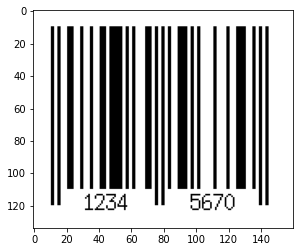

In [16]:
plt.imshow(roi_image, 'gray')

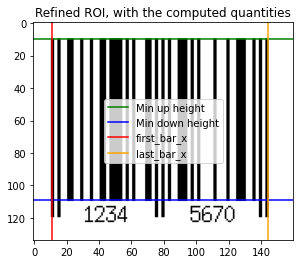

In [17]:
%matplotlib inline
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

### Bars inspection
Let's inspect the computed quantities bar by bar.

In [18]:
print('bars_start: ', bars_start)
print('len:', len(bars_start))

bars_start:  [11, 15, 21, 29, 35, 41, 47, 57, 61, 69, 75, 79, 83, 89, 97, 101, 111, 119, 125, 135, 139, 143]
len: 22


In [19]:
print('bars_width: ', bars_width)
print('len:', len(bars_width))

bars_width:  [2, 2, 4, 2, 2, 4, 8, 2, 2, 4, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2]
len: 22


In [20]:
print('bars_halfHeightUp: ', bars_halfHeightUp)
print('len:', len(bars_halfHeightUp))

bars_halfHeightUp:  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
len: 22


In [21]:
print('bars_halfHeightDown: ', bars_halfHeightDown)
print('len:', len(bars_halfHeightDown))

bars_halfHeightDown:  [53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53]
len: 22


<IPython.core.display.Javascript object>


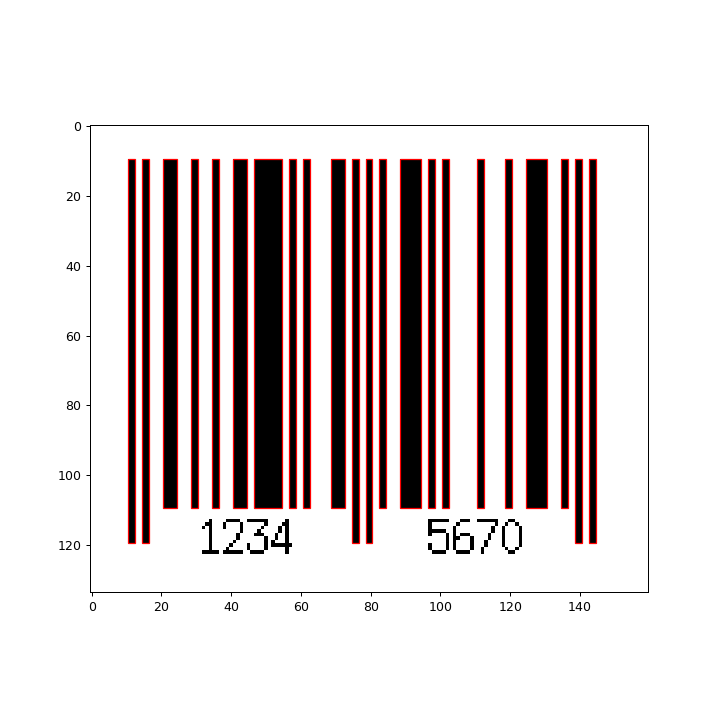

In [22]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi_image, 'gray')
n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

## ALGORITHM 4

The starting point is the algorithm $3$, but we want to get rid of the mean. Indeed: by using the mean, we compute floating point numbers, which must be rounded; the mean is not robust with respect to outliers.

Instead of the mean, we use the **mode**: basically, we compute the most frequent $X_{curr}$.

### Idea
It's like the algorithm $3$, but rather than computing the mean $X_{curr\_left}$ to the left of $i_{mid}$ and the mean $X_{curr\_right}$ to the right of $i_{mid}$, we compute the most frequent $X_{curr\_left}$ and the most frequent $X_{curr\_right}$. This is implemented using a table.

In [79]:
half_height = int(bb_height/2)
half_height_index = half_height-1
half_width = int(bb_width/2)

# INIZIALIZATION
i = 0  # Index for iterating over the pixels

bars_start = []
bars_width = []
bars_halfHeightUp = []
bars_halfHeightDown = []

X_curr_left_table = np.zeros((half_width-1))
X_curr_right_table = np.zeros((half_width-1))

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:

    # White pixel: we go to the next pixel
    if ROI_thresh[half_height_index, i]==255:
        i += 1
        continue

    # Black pixel
    # 'i' is the first pixel in this current barcode bar

    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1

    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height_index, i_end]==0:
        X_curr += 1
        i_end += 1
        
    i_next = i_end

    # Now we search upward and downward
    # Index for goind upward.
    j_up = half_height_index-1
    # Index for goind downward.
    j_down = half_height_index+1
    # Half upward height of this current bar
    half_height_up_curr = 0
    # Half downard height of this current bar
    half_height_down_curr = 0
    
    i_med = int((i+i_end-1)/2)
    
    X_curr_left_table *= 0
    X_curr_left_table[i_med-i] += 1
    X_curr_right_table *= 0
    X_curr_right_table[i_end-i_med-1] += 1

    # Flag saying whether the max up height has been reached or not
    up_reached = j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.3
    # Flag saying whether the max down height has been reached or not
    down_reached = j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.3
    #print(7)

    # Cycle, in which we go upward and downard at the same time, for computing `half_height_up_curr` and 
    # `half_height_down_curr`
    while not up_reached or not down_reached:

        if not up_reached:
            half_height_up_curr += 1
        if not down_reached:
            half_height_down_curr += 1
        
        if not up_reached:  # Vertical level `j_up`
            X_curr_left_up = 0
            X_curr_right_up = 0
            ii = 1
            left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
            right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
            while not left_reached or not right_reached:  
                if not left_reached:
                    X_curr_left_up += 1
                if not right_reached:
                    X_curr_right_up += 1
                ii += 1 
                left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
                right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
            X_curr_left_table[X_curr_left_up] += 1
            X_curr_right_table[X_curr_right_up] += 1
            
        if not down_reached:  # Vertical level `j_up`
            X_curr_left_down = 0
            X_curr_right_down = 0
            ii = 1
            left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
            right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
            while not left_reached or not right_reached:  
                if not left_reached:
                    X_curr_left_down += 1
                if not right_reached:
                    X_curr_right_down += 1
                ii += 1 
                left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
                right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
            X_curr_left_table[X_curr_left_up] += 1
            X_curr_right_table[X_curr_right_up] += 1
            
        X_curr_left = np.argmax(X_curr_left_table)   
        X_curr_right = np.argmax(X_curr_right_table)  
            
        i = i_med-X_curr_left
        i_end = i_med+X_curr_right+1
        X_curr = X_curr_left+X_curr_right+1

        j_up -= 1
        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.33              

        j_down += 1
        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.33     


    # Now we have computed the actual `X_curr`  

    bars_start.append(i)
    bars_width.append(X_curr)
    bars_halfHeightUp.append(half_height_up_curr)
    bars_halfHeightDown.append(half_height_down_curr)

    # We update `i`: we pass to the white pixel right after the current bar
    i = i_next

### Compute the classic quantities

In [80]:
first_bar_x = min(bars_start)

last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1

X = min(bars_width)

min_half_height_up = min(bars_halfHeightUp)

min_half_height_down = min(bars_halfHeightDown)

In [81]:
print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

first_bar_x: 11
last_bar_x: 144
X: 2
min_half_height_up: 56
min_half_height_down: 43


They are correct! Compare them with the previous notebook.

In [82]:
plt.imshow(roi_image, 'gray')

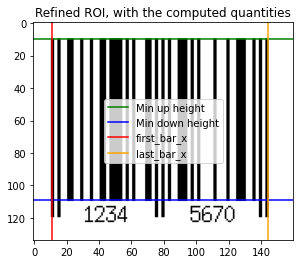

In [83]:
%matplotlib inline
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

### Bars inspection
Let's inspect the computed quantities bar by bar.

In [84]:
print('bars_start: ', bars_start)
print('len:', len(bars_start))

bars_start:  [11, 15, 21, 29, 35, 41, 47, 57, 61, 69, 75, 79, 83, 89, 97, 101, 111, 119, 125, 135, 139, 143]
len: 22


In [85]:
print('bars_width: ', bars_width)
print('len:', len(bars_width))

bars_width:  [2, 2, 4, 2, 2, 4, 8, 2, 2, 4, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2]
len: 22


In [86]:
print('bars_halfHeightUp: ', bars_halfHeightUp)
print('len:', len(bars_halfHeightUp))

bars_halfHeightUp:  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
len: 22


In [87]:
print('bars_halfHeightDown: ', bars_halfHeightDown)
print('len:', len(bars_halfHeightDown))

bars_halfHeightDown:  [53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53]
len: 22


<IPython.core.display.Javascript object>


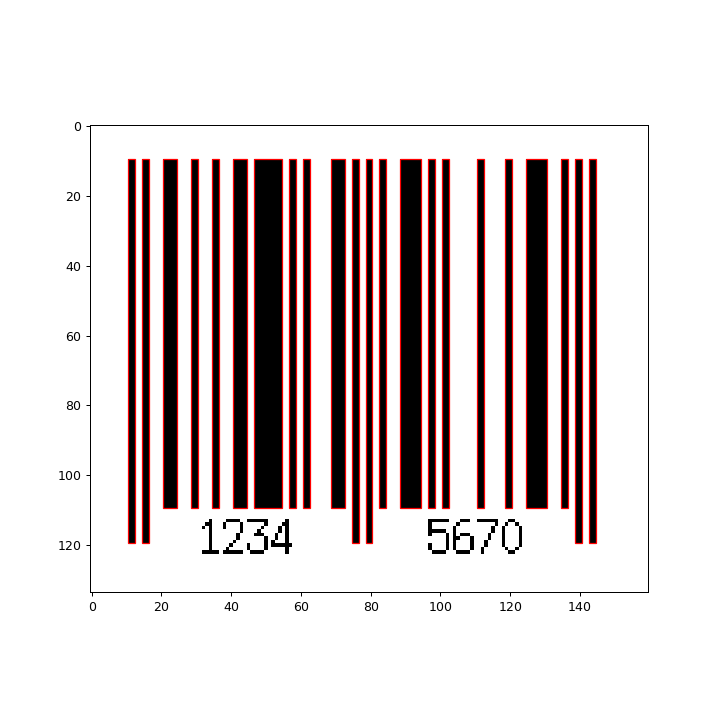

In [88]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi_image, 'gray')
n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

## ALGORITHM 5 (DOES NOT WORK)

In [50]:
def find_half_heights(ROI_thresh, i_med, min_height_index_up, max_height_index_up, min_height_index_down, 
                      max_height_index_down, X_curr_left_table, X_curr_right_table, up_finished, down_finished):
    print(min_height_index_up, max_height_index_up, min_height_index_down, max_height_index_down)

    # Understand if we have reached the up-top of this current bar.
    # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
    # of course, if we are outside the image.
    up_finished = up_finished or min_height_index_up==max_height_index_up         

    # Understand if we have reached the down-top of this current bar.
    # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
    # of course, if we are outside the image.
    down_finished = down_finished or min_height_index_down==max_height_index_down
    
    if up_finished and down_finished:
        height_index_up = min_height_index_up  # max_height_index_up
        height_index_down = min_height_index_down  # max_height_index_down
        return height_index_up, height_index_down
    
    X_curr_left = np.argmax(X_curr_left_table)   
    X_curr_right = np.argmax(X_curr_right_table)  

    i = i_med-X_curr_left
    i_end = i_med+X_curr_right+1
    X_curr = X_curr_left+X_curr_right+1
    
    if not up_finished:  # Vertical level `j_up`
        j_up = math.ceil((min_height_index_up+max_height_index_up)/2)
        up_reached = ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.9 
        if up_reached:
            min_height_index_up = j_up
        else:
            X_curr_left_up = 0
            X_curr_right_up = 0
            ii = 1
            left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
            right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
            while not left_reached or not right_reached:  
                if not left_reached:
                    X_curr_left_up += 1
                if not right_reached:
                    X_curr_right_up += 1
                ii += 1 
                left_reached = i_med-ii<0 or ROI_thresh[j_up, i_med-ii]==255
                right_reached = i_med+ii<0 or ROI_thresh[j_up, i_med+ii]==255
            X_curr_left_table[X_curr_left_up] += 1
            X_curr_right_table[X_curr_right_up] += 1
            max_height_index_up = j_up-1

    if not down_finished:  # Vertical level `j_down`
        j_down = int((min_height_index_down+max_height_index_down)/2)
        down_reached = ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.9  
        if down_reached:
            max_height_index_down = j_down
        else:
            X_curr_left_down = 0
            X_curr_right_down = 0
            ii = 1
            left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
            right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
            while not left_reached or not right_reached:  
                if not left_reached:
                    X_curr_left_down += 1
                if not right_reached:
                    X_curr_right_down += 1
                ii += 1 
                left_reached = i_med-ii<0 or ROI_thresh[j_down, i_med-ii]==255
                right_reached = i_med+ii<0 or ROI_thresh[j_down, i_med+ii]==255
            X_curr_left_table[X_curr_left_down] += 1
            X_curr_right_table[X_curr_right_down] += 1
            min_height_index_down = j_down+1
            
    return find_half_heights(ROI_thresh, i_med, min_height_index_up, max_height_index_up, min_height_index_down, 
                      max_height_index_down, X_curr_left_table, X_curr_right_table, up_finished, down_finished)

In [51]:
half_height = int(bb_height/2)
half_height_index = half_height-1
half_width = int(bb_width/2)

# INIZIALIZATION
i = 0  # Index for iterating over the pixels

bars_start = []
bars_width = []
bars_halfHeightUp = []
bars_halfHeightDown = []

X_curr_left_table = np.zeros((half_width-1))
X_curr_right_table = np.zeros((half_width-1))

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:

    # White pixel: we go to the next pixel
    if ROI_thresh[half_height_index, i]==255:
        i += 1
        continue

    # Black pixel
    # 'i' is the first pixel in this current barcode bar

    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1

    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height_index, i_end]==0:
        X_curr += 1
        i_end += 1
        
    i_med = int((i+i_end-1)/2)
    
    X_curr_left_table *= 0
    X_curr_left_table[i_med-i] += 1
    X_curr_right_table *= 0
    X_curr_right_table[i_end-i_med-1] += 1

    min_height_index_up, max_height_index_up = 0, half_height_index-1
    min_height_index_down, max_height_index_down = half_height_index+1, bb_height-1
    height_index_up, height_index_down = find_half_heights(ROI_thresh, i_med, min_height_index_up,
                                                                   max_height_index_up, min_height_index_down, 
                                                                   max_height_index_down, X_curr_left_table, 
                                                                   X_curr_right_table, up_finished=False, 
                                                                   down_finished=False) 
    
    half_height_up_curr = half_height - height_index_up - 2
    half_height_down_curr = height_index_down- half_height 

    X_curr_left = np.argmax(X_curr_left_table)   
    X_curr_right = np.argmax(X_curr_right_table) 
    i = i_med-X_curr_left
    i_end = i_med+X_curr_right+1
    X_curr = X_curr_left+X_curr_right+1

    # Now we have computed the actual `X_curr`  

    bars_start.append(i)
    bars_width.append(X_curr)
    bars_halfHeightUp.append(half_height_up_curr)
    bars_halfHeightDown.append(half_height_down_curr)

    # We update `i`: we pass to the white pixel right after the current bar
    i = i_end

0 65 67 133
0 32 101 133
0 15 118 133
8 15 118 125
8 11 118 121
8 9 120 121
9 9 120 120
0 65 67 133
0 32 101 133
0 15 118 133
8 15 118 125
8 11 118 121
8 9 120 121
9 9 120 120
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 101 117
8 15 110 117
8 11 110 113
8 9 110 111
9 9 110 110
0 65 67 133
0 32 101 133
0 15 118 133
8 15 118 125
8 11 118 121
8 9 120 121
9 9 120 120
0 65 67 133
0 32 101 133
0 15 11

### Compute the classic quantities

In [52]:
first_bar_x = min(bars_start)

last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1

X = min(bars_width)

min_half_height_up = min(bars_halfHeightUp)

min_half_height_down = min(bars_halfHeightDown)

In [53]:
print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

first_bar_x: 11
last_bar_x: 144
X: 2
min_half_height_up: 56
min_half_height_down: 43


They are correct! Compare them with the previous notebook.

In [54]:
plt.imshow(roi_image, 'gray')

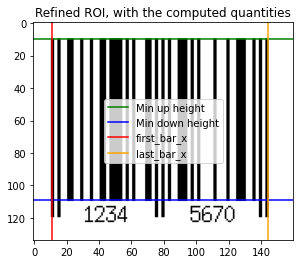

In [55]:
%matplotlib inline
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

### Bars inspection
Let's inspect the computed quantities bar by bar.

In [56]:
print('bars_start: ', bars_start)
print('len:', len(bars_start))

bars_start:  [11, 15, 21, 29, 35, 41, 47, 57, 61, 69, 75, 79, 83, 89, 97, 101, 111, 119, 125, 135, 139, 143]
len: 22


In [57]:
print('bars_width: ', bars_width)
print('len:', len(bars_width))

bars_width:  [2, 2, 4, 2, 2, 4, 8, 2, 2, 4, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2]
len: 22


In [58]:
print('bars_halfHeightUp: ', bars_halfHeightUp)
print('len:', len(bars_halfHeightUp))

bars_halfHeightUp:  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
len: 22


In [59]:
print('bars_halfHeightDown: ', bars_halfHeightDown)
print('len:', len(bars_halfHeightDown))

bars_halfHeightDown:  [53, 53, 43, 43, 43, 43, 43, 43, 43, 43, 53, 53, 43, 43, 47, 47, 47, 43, 43, 43, 53, 53]
len: 22


<IPython.core.display.Javascript object>


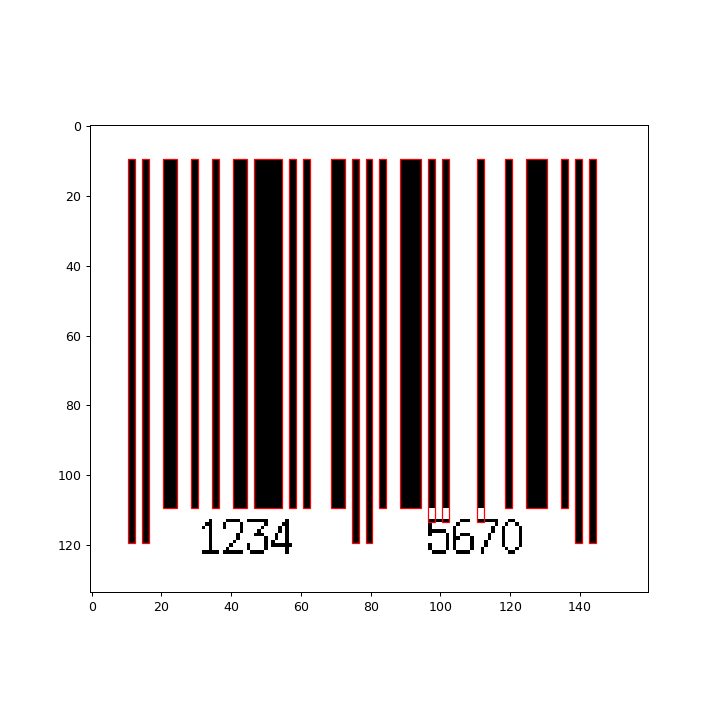

In [60]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi_image, 'gray')
n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

### Compute the classic quantities

In [65]:
first_bar_x = min(bars_start)

last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1

X = min(bars_width)

min_half_height_up = min(bars_halfHeightUp)

min_half_height_down = min(bars_halfHeightDown)

In [66]:
print(first_bar_found)

print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

True
first_bar_x: 13
last_bar_x: 557
X: 4
min_half_height_up: 175
min_half_height_down: 224


They are correct! Compare them with the previous notebook.

In [67]:
plt.imshow(roi_image, 'gray')

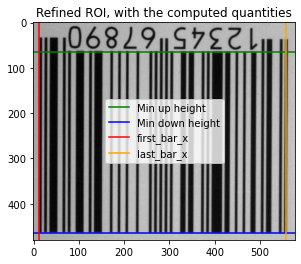

In [68]:
%matplotlib inline
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

### Bars inspection
Let's inspect the computed quantities bar by bar.

In [69]:
print('bars_start: ', bars_start)
print('len:', len(bars_start))

bars_start:  [13, 24, 36, 65, 76, 94, 123, 134, 169, 187, 204, 227, 255, 267, 278, 290, 301, 324, 342, 370, 382, 393, 422, 445, 462, 479, 502, 514, 542, 554]
len: 30


In [70]:
print('bars_width: ', bars_width)
print('len:', len(bars_width))

bars_width:  [5, 5, 17, 5, 5, 16, 5, 16, 4, 4, 4, 4, 5, 5, 5, 4, 4, 10, 10, 4, 4, 22, 10, 4, 4, 10, 4, 10, 4, 4]
len: 30


In [71]:
print('bars_halfHeightUp: ', bars_halfHeightUp)
print('len:', len(bars_halfHeightUp))

bars_halfHeightUp:  [207, 207, 207, 207, 178, 178, 177, 177, 177, 177, 177, 177, 176, 176, 205, 205, 176, 176, 176, 176, 176, 176, 175, 175, 175, 175, 204, 203, 203, 203]
len: 30


In [72]:
print('bars_halfHeightDown: ', bars_halfHeightDown)
print('len:', len(bars_halfHeightDown))

bars_halfHeightDown:  [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
len: 30


<IPython.core.display.Javascript object>


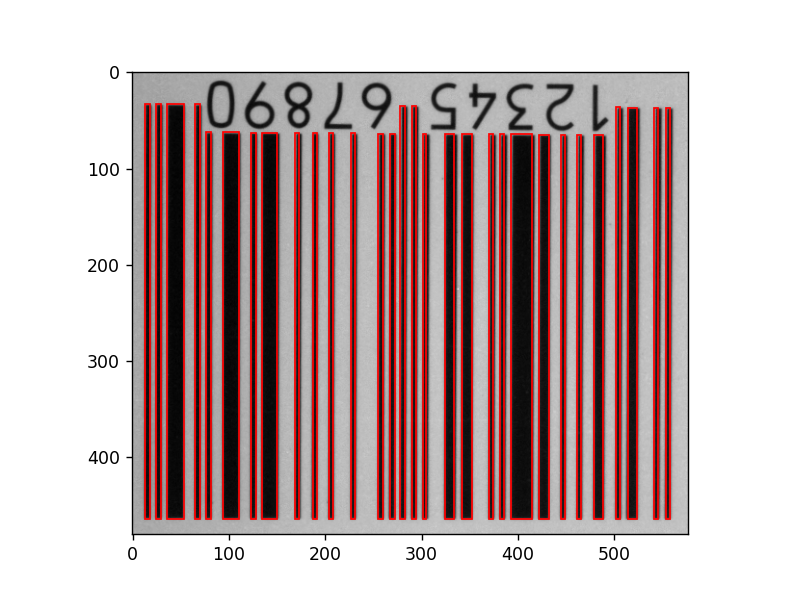

In [73]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots()

ax.imshow(roi_image, 'gray')

n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b], half_height-bars_halfHeightUp[b]), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

It seems less good... The bars are shrinked too much... 

However, an example in which this solution $3$ works better is now shown.

### Example in which algorithm $3$ works better

In [77]:
image_path = f'../images/{images_paths[12]}'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=False)
image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=False)
image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=False)
gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                             int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]
_ ,ROI_thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
half_height = int(bb_height/2)

C:\Users\pitti\Desktop\Artificial Intelligence - Master degree\First year\Computer Vision and Image Processing\Project\Barcodes-verification\2) ROI refinement\2) rotate_image_boundingBox.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  angle2 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))


Algorithm $2$

In [78]:
# INIZIALIZATION
i = 0  # Index for iterating over the pixels

bars_start = []
bars_width = []
bars_halfHeightUp = []
bars_halfHeightDown = []

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:
    
    # White pixel: we go to the next pixel
    if ROI_thresh[half_height, i]==255:
        i += 1
        continue
    
    # Black pixel
    # 'i' is the first pixel in this current barcode bar
        
    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1
    
    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height, i_end]==0:
        X_curr += 1
        i_end += 1
       
    # Now we search upward and downward along the vertical line 'i'.
    # Index for goind upward.
    j_up = half_height-1
    # Index for goind downward.
    j_down = half_height+1
    # Half upward height of this current bar
    min_half_height_up_curr = 1
    # Half downard height of this current bar
    min_half_height_down_curr = 1
    
    # Flag saying whether the max up height has been reached or not
    up_reached = False
    # Flag saying whether the max down height has been reached or not
    down_reached = False
    
    #print(7)

    # Cycle, in which we go upward and downard at the same time, for computing `min_half_height_up_curr` and 
    # `min_half_height_down_curr`
    while not up_reached or not down_reached:
        """X_tmp_up = X_curr
        X_tmp_bottom = X_curr

        if not up_reached:
            while thresh[j_up, i-1]==0:  #######
                X_tmp_up += 1
                i -= 1 
            while thresh[j_up, j]==0:
                X_tmp_up += 1
                j +=1 
        if not bottom_reached:
            while thresh[j_bottom, i-1]==0:  ##########
                X_tmp_bottom += 1
                i -= 1 
            while thresh[j_bottom, j]==0:
                X_tmp_bottom += 1
                j +=1 
        X_curr = max([X_tmp_up,X_tmp_bottom])"""
        
        #print(11)
        #print(up_reached,down_reached)
        
        # We separate the increasing of `X_curr` left, right, up, down: 4 possibilities
        
        # Left increasing of `X_curr` on the vertical level `j_up`. "Left increasing" means before the index `i`.
        X_inc_left_up = 0
        # Right increasing of `X_curr` on the vertical level `j_up`. "Right increasing" means before the index `i_end`.
        X_inc_right_up = 0
        # Left increasing of `X_curr` on the vertical level `j_down`. "Left increasing" means before the index `i`.
        X_inc_left_down = 0
        # Right increasing of `X_curr` on the vertical level `j_down`. "Right increasing" means before the index `i_end`.
        X_inc_right_down = 0

        if not up_reached:  # Vertical level `j_up`
            while ROI_thresh[j_up, i-1]==0:  # Left expansion of `X_curr`
                #print(8)
                X_inc_left_up += 1
                i -= 1 
            while ROI_thresh[j_up, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_up += 1
                i_end +=1 
        if not down_reached:  # Vertical level `j_down`
            while ROI_thresh[j_down, i-1]==0:  # Left expansion of `X_curr`
                X_inc_left_down += 1
                i -= 1 
            while ROI_thresh[j_down, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_down += 1
                i_end +=1 
        
        # Update `X_curr`, adding the maximum, both left and right.
        X_curr += max([X_inc_left_up,X_inc_left_down]) + max([X_inc_right_up,X_inc_right_down])

        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<=0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.25
        """if X_curr==1 and not up_reached :
           foreground_perc_points = (thresh[0:j_up, i]==0).sum()/thresh[0:j_up, i].shape[0]
           #print('Up', foreground_perc_points)
           up_reached = j_up<=0 or foreground_perc_points<0.1"""
        # We have not reached the up-top yet: update `j_up` and `min_half_height_up_curr`
        if not up_reached:
            j_up -= 1
            min_half_height_up_curr += 1

        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>=bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.25
        """if X_curr==1 and not bottom_reached:
           #bottom_reached = j_bottom>=bb_height-1 or np.all(thresh[j_bottom+1:min([bb_height-1,j_bottom+4]), i]==255)
           foreground_perc_points = (thresh[j_bottom:, i]==0).sum()/thresh[j_bottom:, i].shape[0]
           #print('Bottom', foreground_perc_points)
           bottom_reached = j_bottom>=bb_height-1 or foreground_perc_points<0.1"""
        if not down_reached:
            j_down += 1
            min_half_height_down_curr += 1
            
    # Now we have computed the actual `X_curr`
                
    bars_start.append(i)
    bars_width.append(X_curr)
    bars_halfHeightUp.append(min_half_height_up_curr)
    bars_halfHeightDown.append(min_half_height_down_curr)
        
    # We update `i`: we pass to the white pixel right after the current bar
    i = i_end

<IPython.core.display.Javascript object>


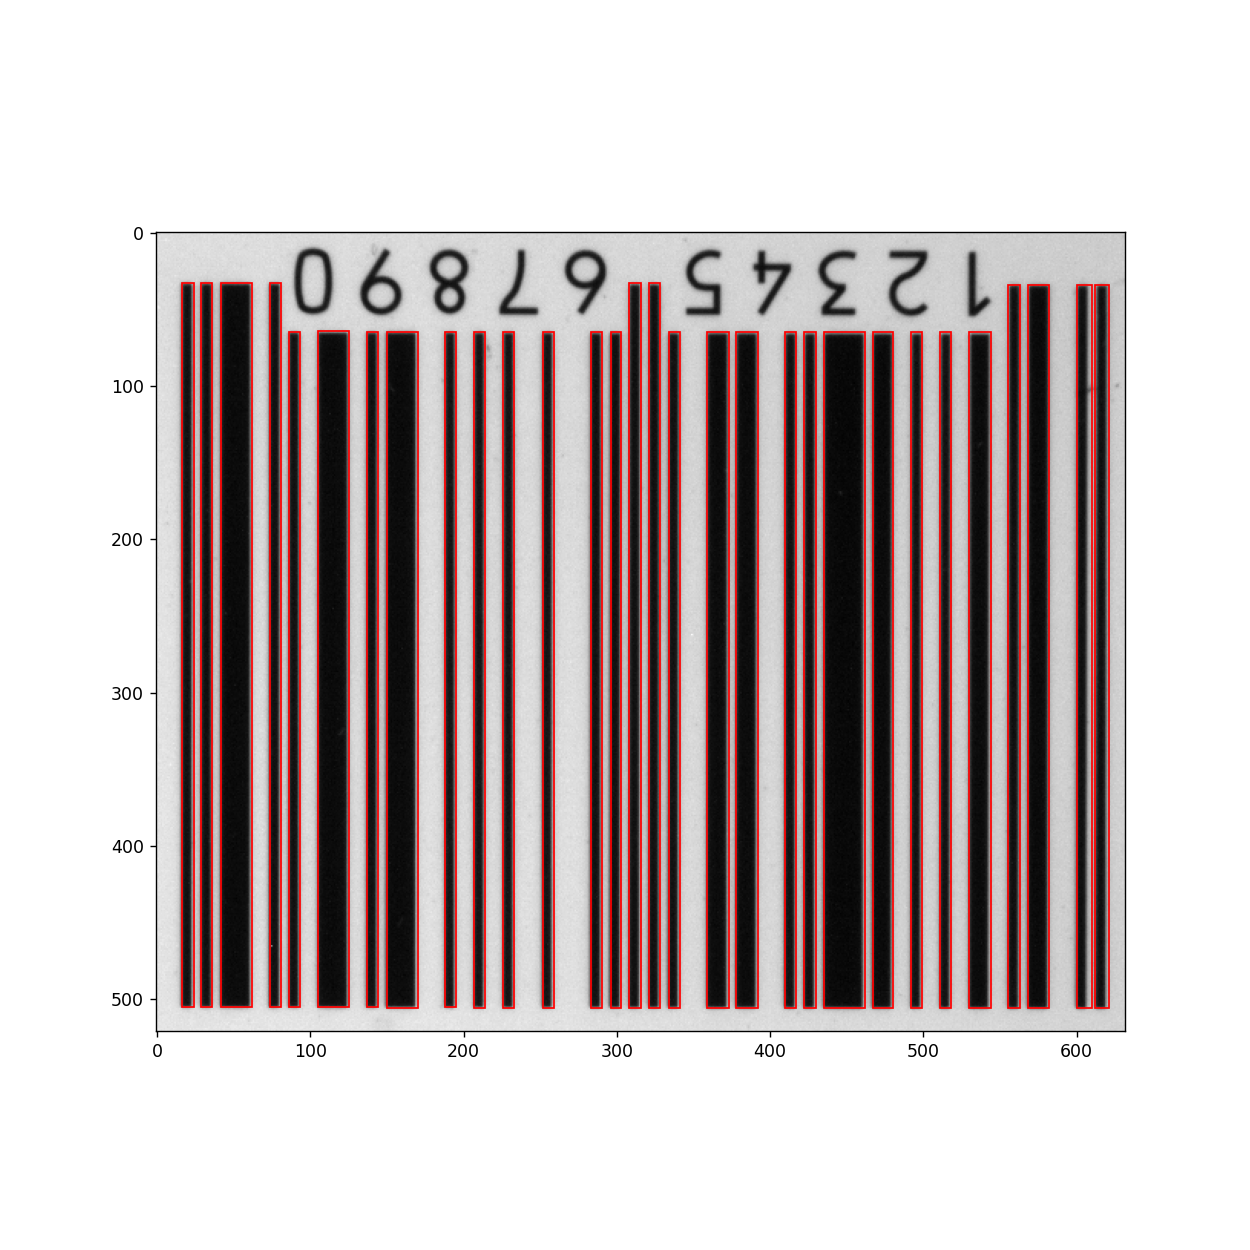

In [80]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(roi_image, 'gray')

n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b], half_height-bars_halfHeightUp[b]), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

The second bar from the left is clearly over-estimated...

Let's use algorithm $3$

In [81]:
# INIZIALIZATION
i = 0  # Index for iterating over the pixels

bars_start = []
bars_width = []
bars_halfHeightUp = []
bars_halfHeightDown = []

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:
    
    # White pixel: we go to the next pixel
    if ROI_thresh[half_height, i]==255:
        i += 1
        continue
    
    # Black pixel
    # 'i' is the first pixel in this current barcode bar
    
    # First time we see a barcode bar
    if not first_bar_found:
        first_bar_x = i
        first_bar_found = True 
        
    # Width of this current bar
    X_curr = 1    
    
    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height, i+X_curr]==0:
        X_curr += 1
        
    i_next = i+X_curr
       
    # Now we search vertically upward and downward along that bar
    # Index for goind upward.
    j_up = half_height-1
    # Index for goind downward.
    j_down = half_height+1
    # Half upward height of this current bar
    min_half_height_up_curr = 1
    # Half downard height of this current bar
    min_half_height_down_curr = 1
    
    # Number of vertical levels explored so far
    l = 1
    i_med = int(i+X_curr/2)
    
    # Flag saying whether the max up height has been reached or not
    up_reached = False
    # Flag saying whether the max down height has been reached or not
    down_reached = False
    
    #print(i, i_med, X_curr)

    # Cycle, in which we go upward and downard at the same time, for computing `min_half_height_up_curr` and 
    # `min_half_height_down_curr`
    while not up_reached or not down_reached:
        if not up_reached:
            X_curr_tmp_up = 0
            ii = 1
            i_tmp_up = i_med 
            while ROI_thresh[j_up, i_med-ii]==0 or ROI_thresh[j_up, i_med+ii]==0:
                if ROI_thresh[j_up, i_med-ii]==0:
                    X_curr_tmp_up += 1
                    i_tmp_up -= 1
                if ROI_thresh[j_up, i_med+ii]==0:
                    X_curr_tmp_up += 1
                ii += 1                
            X_curr = (l*X_curr + X_curr_tmp_up)/(l+1)
            i = (l*i + i_tmp_up)/(l+1)
            l = l+1
                
        if not down_reached:
            X_curr_tmp_down = 0
            ii = 1
            i_tmp_down = i_med 
            while ROI_thresh[j_down, i_med-ii]==0 or ROI_thresh[j_down, i_med+ii]==0:
                if ROI_thresh[j_down, i_med-ii]==0:
                    X_curr_tmp_down += 1
                    i_tmp_down -= 1
                if ROI_thresh[j_down, i_med+ii]==0:
                    X_curr_tmp_down += 1
                ii += 1
            X_curr = (l*X_curr + X_curr_tmp_down)/(l+1)
            i = (l*i + i_tmp_down)/(l+1)
            l = l+1
                       
        i_int = int(math.floor(i))
        i_end = int(math.floor(i+X_curr))
        i_med = int(i+X_curr/2)

        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<=0 or ((ROI_thresh[j_up, i_int:i_end]==0).sum()/X_curr)<0.25
        # We have not reached the up-top yet: update `j_up` and `min_half_height_up_curr`
        if not up_reached:
            j_up -= 1
            min_half_height_up_curr += 1

        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>=bb_height-1 or ((ROI_thresh[j_down, i_int:i_end]==0).sum()/X_curr)<0.25
        if not down_reached:
            j_down += 1
            min_half_height_down_curr += 1
            
    i = int(math.floor(i))
    X_curr = int(math.floor(X_curr))
            
    # Now we have computed the actual `X_curr`
            
    bars_start.append(i)
    bars_width.append(X_curr)
    bars_halfHeightUp.append(min_half_height_up_curr)
    bars_halfHeightDown.append(min_half_height_down_curr)
        
    # We update `i`: we pass to the white pixel right after the current bar
    i = i_next

<IPython.core.display.Javascript object>


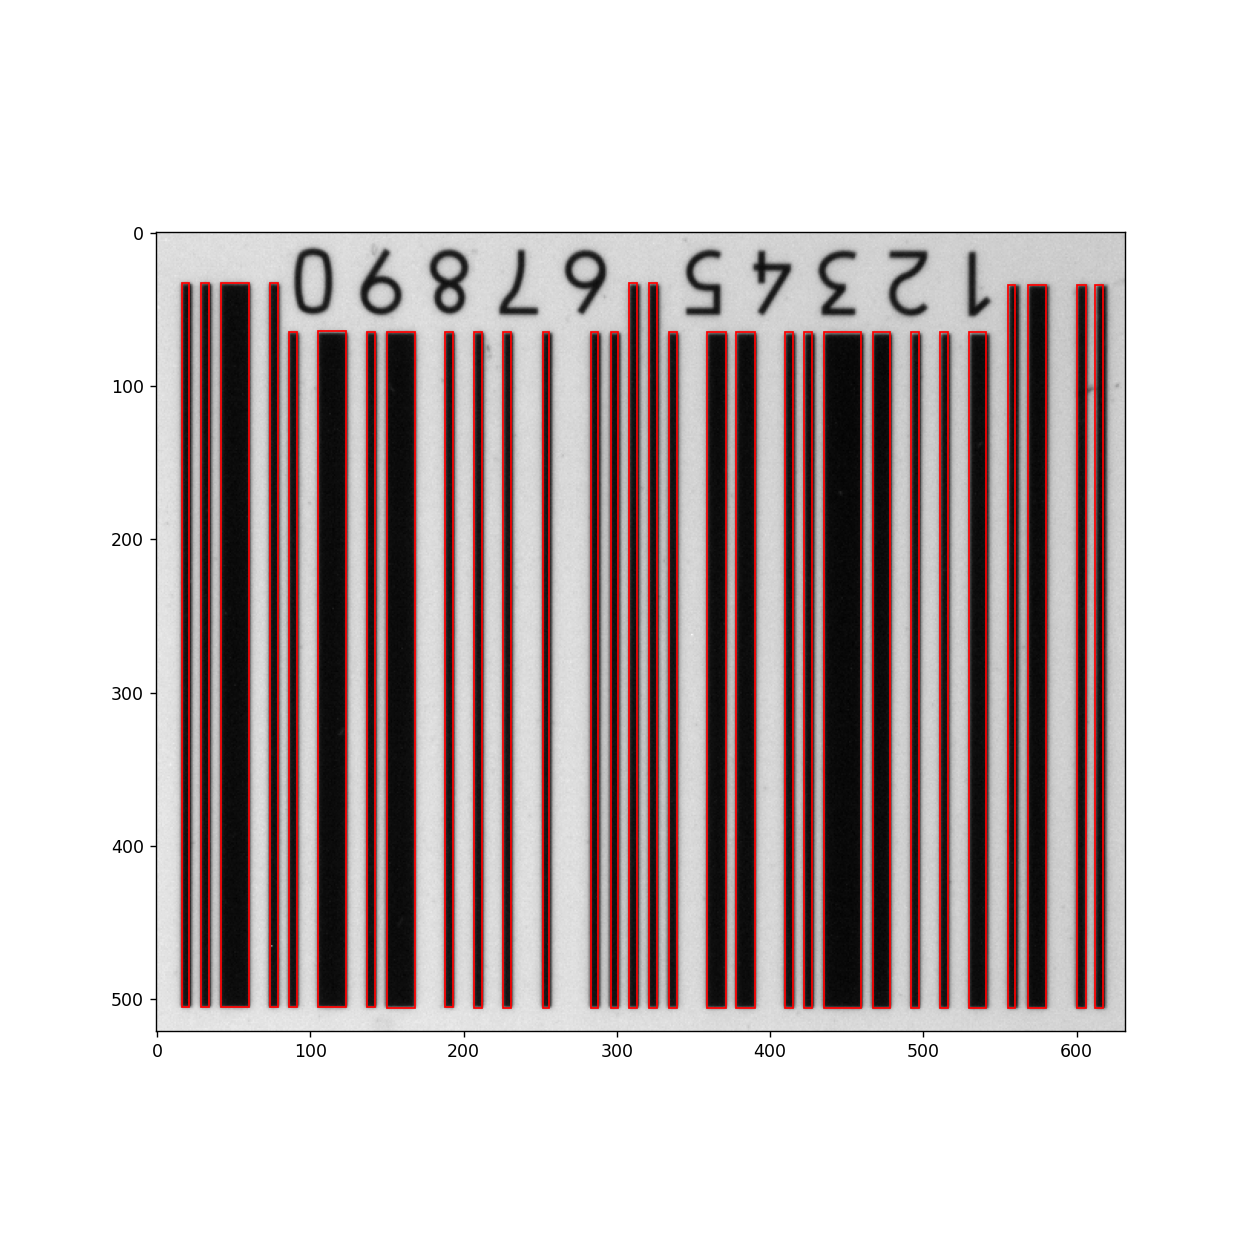

In [82]:
%matplotlib notebook
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(roi_image, 'gray')

n_bars = len(bars_start)
for b in range(n_bars):
    # Create a Rectangle patch
    rect = patches.Rectangle((bars_start[b], half_height-bars_halfHeightUp[b]), bars_width[b], 
                             bars_halfHeightUp[b]+bars_halfHeightDown[b], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [47]:
half_height+min_half_height_down

244

Text(0.5, 1.0, 'Thresholded ROI image')

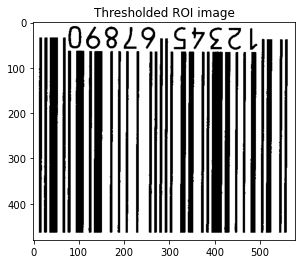

In [60]:

plt.figure()
plt.imshow(ROI_thresh, 'gray')
plt.title('Thresholded ROI image')

Text(0.5, 1.0, 'Thresholded ROI image')

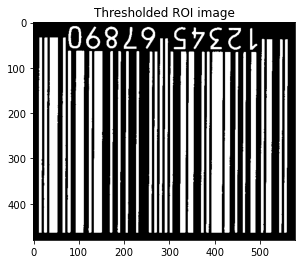

In [61]:
thresh = 255 - ROI_thresh
plt.figure()
plt.imshow(thresh, 'gray')
plt.title('Thresholded ROI image')

In [63]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

Text(0.5, 1.0, 'Thresholded ROI image')

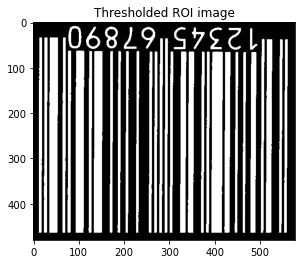

In [64]:
plt.figure()
plt.imshow(closed, 'gray')
plt.title('Thresholded ROI image')

Text(0.5, 1.0, 'Thresholded ROI image')

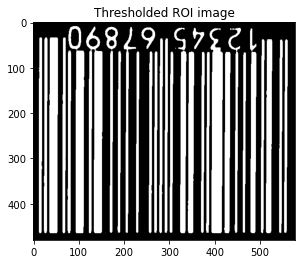

In [65]:
blurred = cv2.blur(roi_image, (1, 10))
_ ,ROI_thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = 255-ROI_thresh
plt.figure()
plt.imshow(thresh, 'gray')
plt.title('Thresholded ROI image')